# **Youtube Comment Spam Detection**

# Imports

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.16.1
KerasNLP version: 0.14.4


In [2]:
df = pd.read_csv("/kaggle/input/youtube-comments-spam-dataset/Youtube-Spam-Dataset.csv")

# EDA

In [3]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


In [4]:
# Basic Information
print("Basic Information:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   VIDEO_NAME  1956 non-null   object
 5   CLASS       1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB
None

Summary Statistics:
             CLASS
count  1956.000000
mean      0.513804
std       0.499937
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


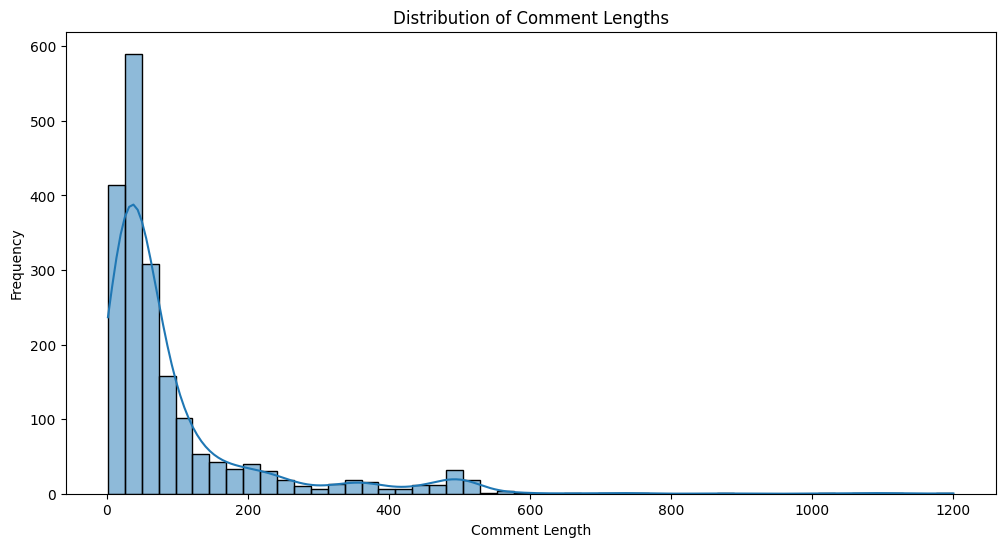

In [5]:
# Comment Length Distribution
df['comment_length'] = df['CONTENT'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df['comment_length'], bins=50, kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()


Class Distribution:


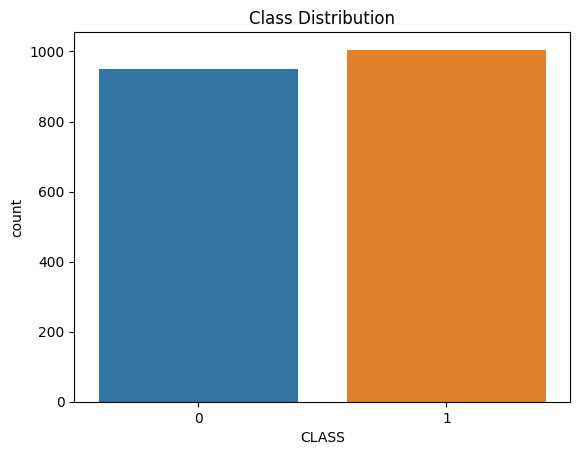

In [6]:
# Class Distribution
print("\nClass Distribution:")
sns.countplot(x='CLASS', data=df)
plt.title('Class Distribution')
plt.show()

# Build & Train Model

In [7]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
X = df['CONTENT'].values
y = df['CLASS'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

In [9]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_comments"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_comments"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
49/49 ━━━━━━━━━━━━━━━━━━━━ 1024s 20s/step - accuracy: 0.6462 - loss: 0.6405 - val_accuracy: 0.9388 - val_loss: 0.2660
Epoch 2/2
49/49 ━━━━━━━━━━━━━━━━━━━━ 1006s 21s/step - accuracy: 0.9353 - loss: 0.2399 - val_accuracy: 0.9643 - val_loss: 0.1405


# Model Analysis

In [11]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Spam","Spam"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

49/49 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step


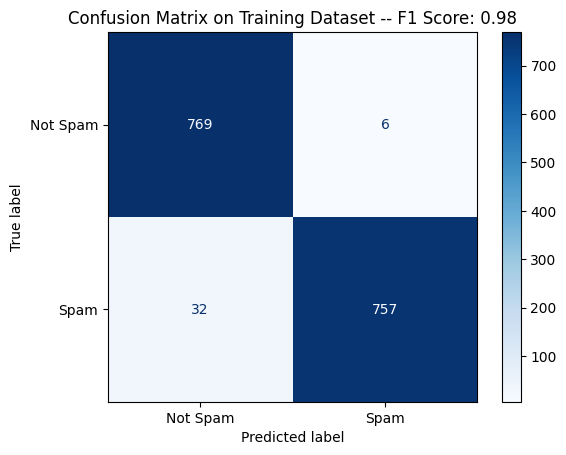

In [12]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step


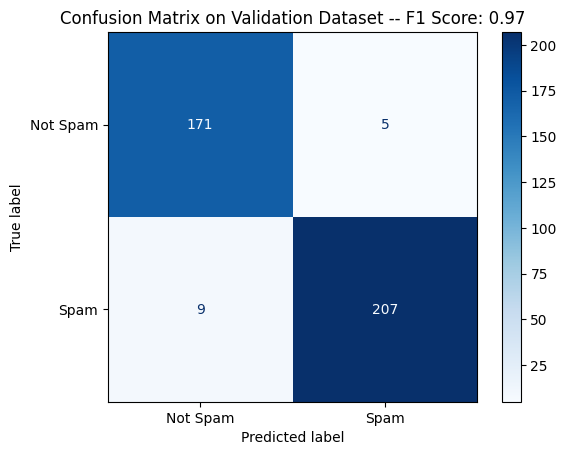

In [13]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [14]:
y_pred_val_labels = np.argmax(y_pred_val, axis=1)
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val_labels, target_names=["Not Spam", "Spam"]))

Validation Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.95      0.97      0.96       176
        Spam       0.98      0.96      0.97       216

    accuracy                           0.96       392
   macro avg       0.96      0.96      0.96       392
weighted avg       0.96      0.96      0.96       392



In [16]:
# Misclassified examples
misclassified_indices = np.where(y_pred_val_labels != y_val)[0]

# Select the misclassified comments from the validation set
misclassified_content = X_val[misclassified_indices]
misclassified_true_labels = y_val[misclassified_indices]
misclassified_pred_labels = y_pred_val_labels[misclassified_indices]

# Create a DataFrame for misclassified examples
misclassified_df = pd.DataFrame({
    'Content': misclassified_content,
    'True Label': misclassified_true_labels,
    'Predicted Label': misclassified_pred_labels
})

print("Misclassified Comments:")
print(misclassified_df.head(10))

Misclassified Comments:
                                             Content  True Label  \
0                     Aslamu Lykum... From Pakistan﻿           1   
1             los invito a subscribirse a mi canal ﻿           1   
2  this song is so addicting. the hook is dope an...           1   
3  The little PSY is suffering Brain Tumor and on...           0   
4                    We can have a party next share﻿           1   
5  OMG I LOVE YOU KATY PARRY YOUR SONGS ROCK!!!!!...           0   
6  Finally someone shares the same opinion as me....           1   
7  thumbs up if u checked this video to see hw vi...           0   
8  ....subscribe......  ......to my........  .......           1   
9                               share your thoughts﻿           1   

   Predicted Label  
0                0  
1                0  
2                0  
3                1  
4                0  
5                1  
6                0  
7                1  
8                0  
9                